## Analysis on Chicago TNC, Taxi, Transit trips in 2020-2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import seaborn as sns
import datetime
import os
from numpy import mean
from dask import dataframe as dd
from prophet import Prophet
from pandas import read_csv
from sklearn.metrics import mean_absolute_error

/Users/xujs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  after removing the cwd from sys.path.


### Calculating taxi trips

In [82]:
# read in files of number of taxi trips in 2019, 2020, 2021 and 2022
df19 = dd.read_csv("Desktop/Taxi_Trips_2019.csv", dtype={'Trip Seconds': 'float64'})
df20 = dd.read_csv("Desktop/Taxi_Trips_2020.csv", dtype={'Trip Seconds': 'float64'})
df21 = dd.read_csv("Desktop/Taxi_Trips_2021.csv", dtype={'Trip Seconds': 'float64'})
df22 = dd.read_csv("Desktop/Taxi_Trips_2022.csv", dtype={'Trip Seconds': 'float64'})

In [83]:
# drop the columns that are not used for calculating the total trips by month and year
df19 = df19.drop(['Tips','Tolls','Pickup Centroid Location','Taxi ID','Trip Seconds','Trip Miles','Fare','Extras','Trip Total','Payment Type','Trip End Timestamp','Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area','Dropoff Community Area','Company','Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude','Dropoff Centroid Longitude'],axis=1)
df20 = df20.drop(['Tips','Tolls','Pickup Centroid Location','Taxi ID','Trip Seconds','Trip Miles','Fare','Extras','Trip Total','Payment Type','Trip End Timestamp','Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area','Dropoff Community Area','Company','Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude','Dropoff Centroid Longitude'],axis=1)
df21 = df21.drop(['Tips','Tolls','Pickup Centroid Location','Taxi ID','Trip Seconds','Trip Miles','Fare','Extras','Trip Total','Payment Type','Trip End Timestamp','Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area','Dropoff Community Area','Company','Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude','Dropoff Centroid Longitude'],axis=1)
df22 = df22.drop(['Tips','Tolls','Pickup Centroid Location','Taxi ID','Trip Seconds','Trip Miles','Fare','Extras','Trip Total','Payment Type','Trip End Timestamp','Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area','Dropoff Community Area','Company','Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude','Dropoff Centroid Longitude'],axis=1)

In [32]:
df20.head()

,Trip ID,Trip Start Timestamp,Dropoff Centroid Location
0,16c7456d99031528c238bd02f40df5ab9bdf9778,01/01/2020 12:00:00 AM,NaN
1,472eef1d5c7a5e5ee033f673942f367dc71869f1,01/01/2020 12:00:00 AM,POINT (-87.5727819867 41.7615779081)
2,031a4d882fb3315a490d0b5c358c945ad9b9856d,01/01/2020 12:00:00 AM,POINT (-87.6333080367 41.899602111)
3,3c416c246829dfb3f78cc93cbc7dfecdd379be15,01/01/2020 12:00:00 AM,POINT (-87.6333080367 41.899602111)
4,3c0a22971ae070ce35e0c03f1b8e92fe7aa840cd,01/01/2020 12:00:00 AM,POINT (-87.6333080367 41.899602111)


In [33]:
# convert to pandas dataframe
df19_pd = df19.compute()
df20_pd = df20.compute()
df21_pd = df21.compute()
df22_pd = df22.compute()

In [85]:
# check the number of rows and colummns of the tables
df19_pd.shape

(16477365, 3)

In [34]:
df20_pd.shape

(3889032, 3)

In [35]:
df21_pd.shape

(3948045, 3)

In [36]:
df22_pd.shape

(6370220, 3)

In [80]:
# check the end date of 2022 data
df22_pd.tail()

,Trip ID,Trip Start Timestamp,Dropoff Centroid Location,Trip Start Date
125850,f6b1d20ab9dd64e648f8babb251493b1f325b6a0,12/31/2022 11:45:00 PM,POINT (-87.8045320063 41.9850151008),2022-12-31 23:45:00
125851,fd681e1a8b980340e3db227fbad6523b2475ed5c,12/31/2022 11:45:00 PM,POINT (-87.6634164054 41.9867117999),2022-12-31 23:45:00
125852,f8facda893ff65a385c5dc6a723d6db8a2a22cee,12/31/2022 11:45:00 PM,POINT (-87.6763559892 41.9012069941),2022-12-31 23:45:00
125853,f9ca3672d82db7fe25c021d0d6a039e12289e146,12/31/2022 11:45:00 PM,POINT (-87.6494887289 41.9226862843),2022-12-31 23:45:00
125854,fa30fb29df815ee27a7f2c5488c8408ddf2bb55c,12/31/2022 11:45:00 PM,POINT (-87.6333080367 41.899602111),2022-12-31 23:45:00


In [37]:
# convert the Trip Start Timestamp to datetime
df19_pd['Trip Start Date']=pd.to_datetime(df19_pd['Trip Start Timestamp'])
df20_pd['Trip Start Date']=pd.to_datetime(df20_pd['Trip Start Timestamp'])
df21_pd['Trip Start Date']=pd.to_datetime(df21_pd['Trip Start Timestamp'])
df22_pd['Trip Start Date']=pd.to_datetime(df22_pd['Trip Start Timestamp'])

In [88]:
# generate the statistical summary table of taxi trips across 2019 and 2022 by month
df_taxi_4y=df19_pd.append(df20_pd)
df_taxi_4y=df_taxi_4y.append(df21_pd)
df_taxi_4y=df_taxi_4y.append(df22_pd)

In [89]:
df_taxi_4y['Trip Start Year Month']= df_taxi_4y['Trip Start Date'].dt.strftime('%Y-%m')

In [90]:
df_taxi_4y_sum = df_taxi_4y.groupby(df_taxi_4y['Trip Start Year Month'])['Trip ID'].count()
df_taxi_4y_sum.to_csv('Desktop/Taxi_Trips_Summary_4y.csv') 

In [267]:
path1 = 'Desktop/Taxi_Trips_Summary_4y.csv'
df1 = read_csv(path1, header=0)
df1.columns=['Trip Month Year', 'Trip Count']

In [268]:
df1.head()

,Trip Month Year,Trip Count
0,2019-01,1213529
1,2019-02,1312782
2,2019-03,1515772
3,2019-04,1458362
4,2019-05,1532337


In [93]:
df1.tail()

,Trip Month Year,Trip Count
43,2022-08,589033
44,2022-09,608507
45,2022-10,606713
46,2022-11,542788
47,2022-12,501384


In [269]:
df1 = df1.loc[df1['Trip Month Year'] < '2022-11']

In [270]:
df1.shape

(46, 2)

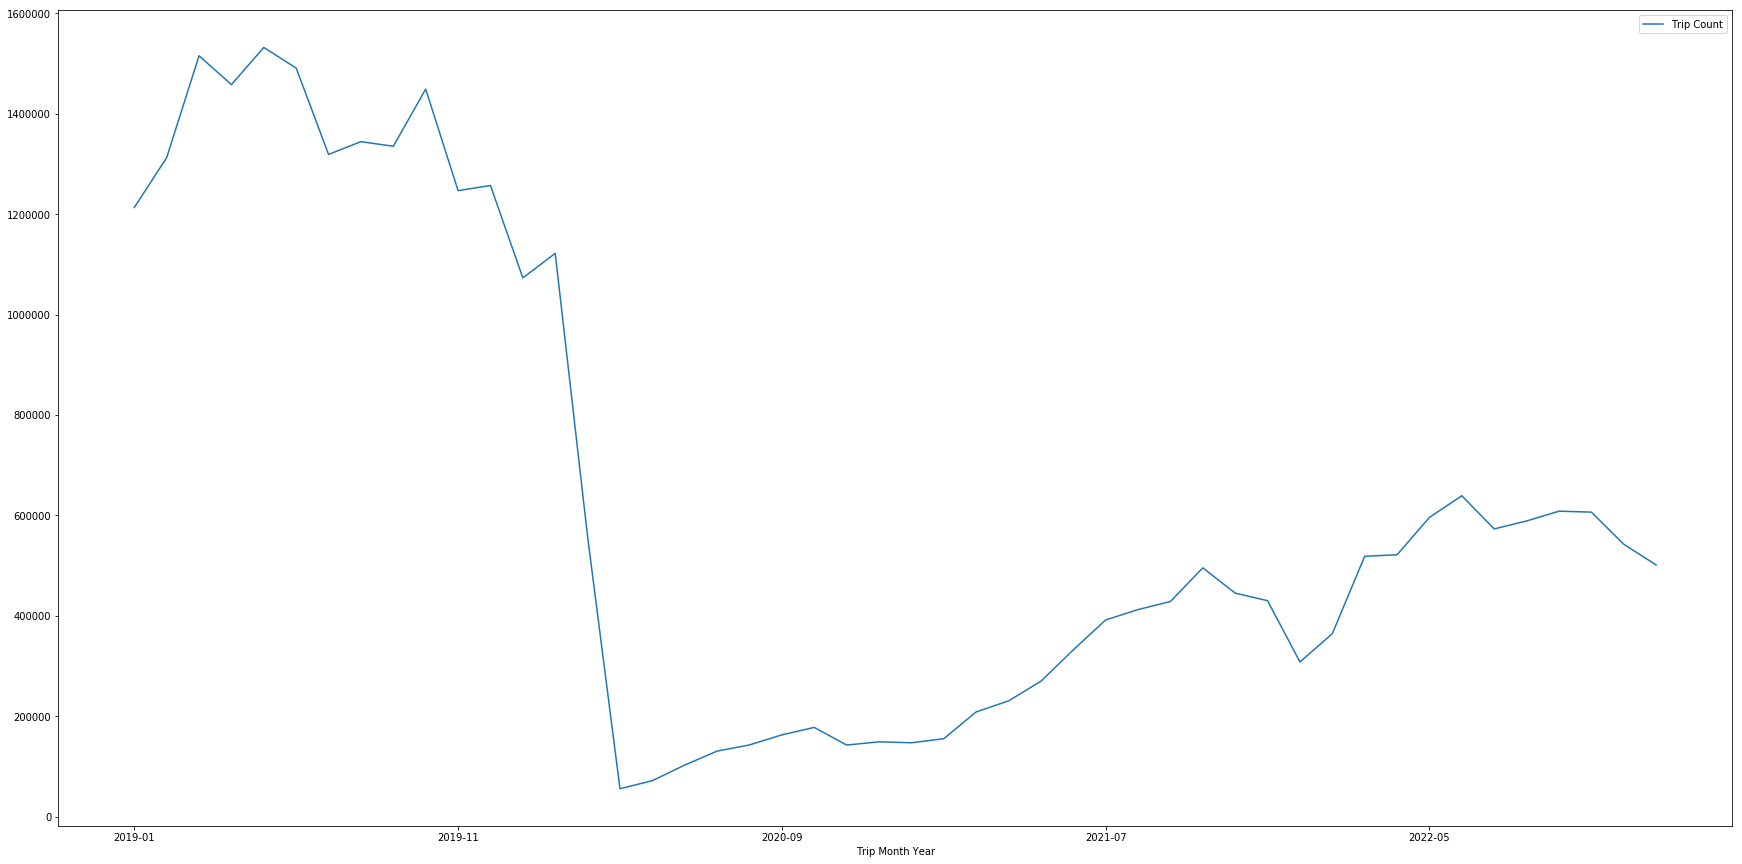

In [94]:
df1.plot('Trip Month Year', 'Trip Count')

### Adding TNC trips

In [147]:
path2 = 'Desktop/Transportation_Network_Providers_Trips_Summary_4y.csv'
df2 = read_csv(path2, header=0)
df2.head()

,Trip Month Year,Trip Count
0,2019-01,8784983
1,2019-02,8849315
2,2019-03,10269143
3,2019-04,9211811
4,2019-05,9706891


In [150]:
df2 = df2.loc[df2['Trip Month Year'] < '2022-11']

In [152]:
df2.shape

(46, 2)

([<matplotlib.axis.XTick at 0x7fd40c32e400>,
 <a list of 46 Text xticklabel objects>)

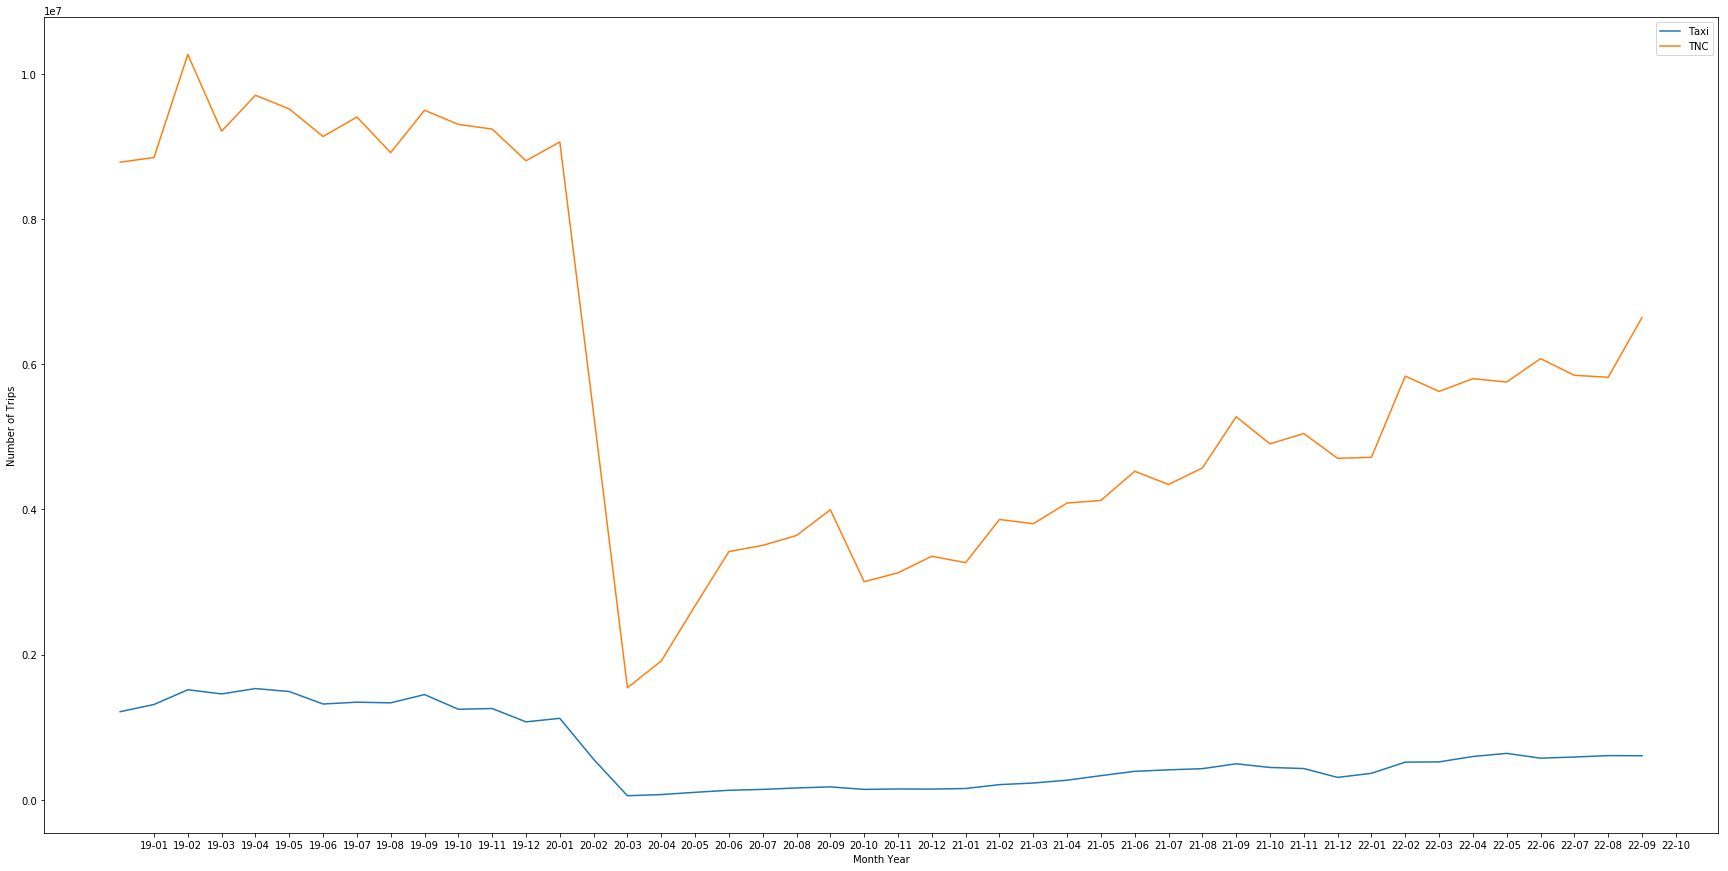

In [153]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46]
labels = ['19-01', '19-02', '19-03', '19-04', '19-05', '19-06','19-07', '19-08', '19-09', '19-10', '19-11', '19-12',
         '20-01', '20-02', '20-03', '20-04', '20-05', '20-06','20-07', '20-08', '20-09', '20-10', '20-11', '20-12',
         '21-01', '21-02', '21-03', '21-04', '21-05', '21-06','21-07', '21-08', '21-09', '21-10', '21-11', '21-12',
         '22-01', '22-02', '22-03', '22-04', '22-05', '22-06','22-07', '22-08', '22-09', '22-10']

graph1 = pd.DataFrame({
    'Taxi': df1['Trip Count'],
    'TNC': df2['Trip Count']})
graph1.plot(kind='line')
plt.xlabel('Month Year')
plt.ylabel('Number of Trips')
plt.xticks(x, labels)

### Adding transit ridership

In [124]:
path3 = 'Desktop/Transit_Trips.csv'
df3 = read_csv(path3, header=0)

In [125]:
df3.head()

,service_date,day_type,bus,rail_boardings,total_rides
0,01/01/2001,U,297192,126455,423647
1,01/02/2001,W,780827,501952,1282779
2,01/03/2001,W,824923,536432,1361355
3,01/04/2001,W,870021,550011,1420032
4,01/05/2001,W,890426,557917,1448343


In [126]:
df3 = df3.drop(['day_type'],axis=1)
df3.columns=['Trip Date', 'Bus', 'Rail', 'Total']

In [127]:
df3['Trip Start Date']=pd.to_datetime(df3['Trip Date'])

In [128]:
df3 = df3.loc[df3['Trip Start Date'] > '2018-12-31']

In [129]:
df3.head()

,Trip Date,Bus,Rail,Total,Trip Start Date
6636,01/01/2019,248879,245852,494731,2019-01-01
6637,01/02/2019,591006,573542,1164548,2019-01-02
6638,01/03/2019,664442,627781,1292223,2019-01-03
6639,01/04/2019,668812,628514,1297326,2019-01-04
6640,01/05/2019,444434,348257,792691,2019-01-05


In [130]:
df3.tail()

,Trip Date,Bus,Rail,Total,Trip Start Date
8031,10/27/2022,528826,395129,923955,2022-10-27
8032,10/28/2022,501985,352842,854827,2022-10-28
8033,10/29/2022,311437,254149,565586,2022-10-29
8034,10/30/2022,217204,177961,395165,2022-10-30
8035,10/31/2022,454862,318942,773804,2022-10-31


In [131]:
df3['Trip Start Year Month']= df3['Trip Start Date'].dt.strftime('%Y-%m')

In [132]:
df_transit_4y_sum = df3.groupby(df3['Trip Start Year Month']).sum()
df_transit_4y_sum.to_csv('Desktop/Transit_Trips_Summary_4y.csv')

In [221]:
path4 = 'Desktop/Transit_Trips_Summary_4y.csv'
df4 = read_csv(path4, header=0)

In [222]:
df4.head()

,Trip Start Year Month,Bus,Rail,Total
0,2019-01,17453868,16068845,33522713
1,2019-02,18278676,16356941,34635617
2,2019-03,20267147,18019169,38286316
3,2019-04,19936880,18385649,38322529
4,2019-05,21144868,19206970,40351838


In [135]:
df4.tail()

,Trip Start Year Month,Bus,Rail,Total
41,2022-06,11995182,9408339,21403521
42,2022-07,11554429,9350624,20905053
43,2022-08,12641823,9649489,22291312
44,2022-09,13266349,10200260,23466609
45,2022-10,13300536,10275760,23576296


In [137]:
df4.shape

(46, 4)

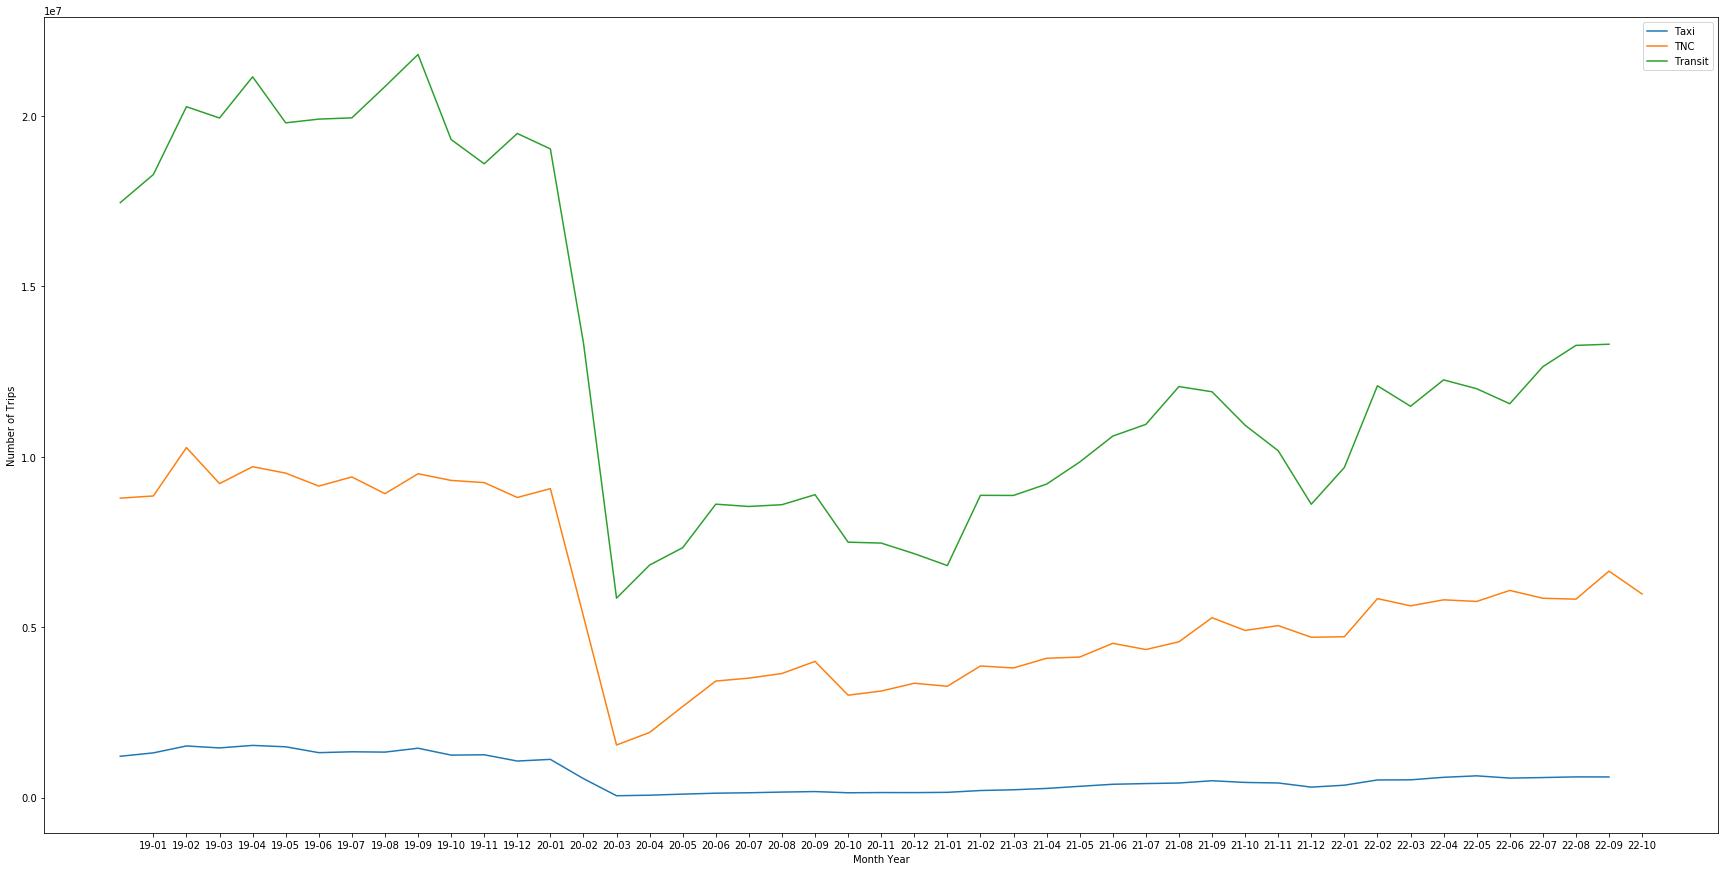

In [149]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46]
labels = ['19-01', '19-02', '19-03', '19-04', '19-05', '19-06','19-07', '19-08', '19-09', '19-10', '19-11', '19-12',
         '20-01', '20-02', '20-03', '20-04', '20-05', '20-06','20-07', '20-08', '20-09', '20-10', '20-11', '20-12',
         '21-01', '21-02', '21-03', '21-04', '21-05', '21-06','21-07', '21-08', '21-09', '21-10', '21-11', '21-12',
         '22-01', '22-02', '22-03', '22-04', '22-05', '22-06','22-07', '22-08', '22-09', '22-10']

graph2 = pd.DataFrame({
    'Taxi': df1['Trip Count'],
    'TNC': df2['Trip Count'],
    'Transit': df4['Bus']})
graph2.plot(kind='line')
plt.xlabel('Month Year')
plt.ylabel('Number of Trips')
plt.xticks(x, labels)
plt.rcParams["figure.figsize"] = (30,15)

### Developing prediction models for taxi, tnc and transit

In [170]:
from pandas import to_datetime
from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
import pmdarima as pm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

### 1. TNC prediction model

In [204]:
# create test dataset, remove last 12 months
train_tnc = df2.drop(df2.index[-10:])
train_tnc = train_tnc.drop(train_tnc.index[:15])
print(train_tnc.head())
print(train_tnc.tail())
train_tnc.columns = ['ds', 'y']
df2.columns = ['ds', 'y']

         ds        y
15  2020-04  1543440
16  2020-05  1912247
17  2020-06  2672854
18  2020-07  3419835
19  2020-08  3505037
         ds        y
31  2021-08  4344194
32  2021-09  4571240
33  2021-10  5277444
34  2021-11  4903719
35  2021-12  5046136


In [205]:
# define the model
model1 = Prophet()
# fit the model
model1.fit(train_tnc)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


In [206]:
future = list()
for i in range(1,11):
    future.append('2022-'+str(i))
future = pd.DataFrame(future)
future.columns = ['ds']

In [207]:
future.head()

,ds
0,2022-1
1,2022-2
2,2022-3
3,2022-4
4,2022-5


In [208]:
future.tail()

,ds
5,2022-6
6,2022-7
7,2022-8
8,2022-9
9,2022-10


In [209]:
# use the model to make a forecast
forecast_tnc = model1.predict(future)

MAE: 277381.353


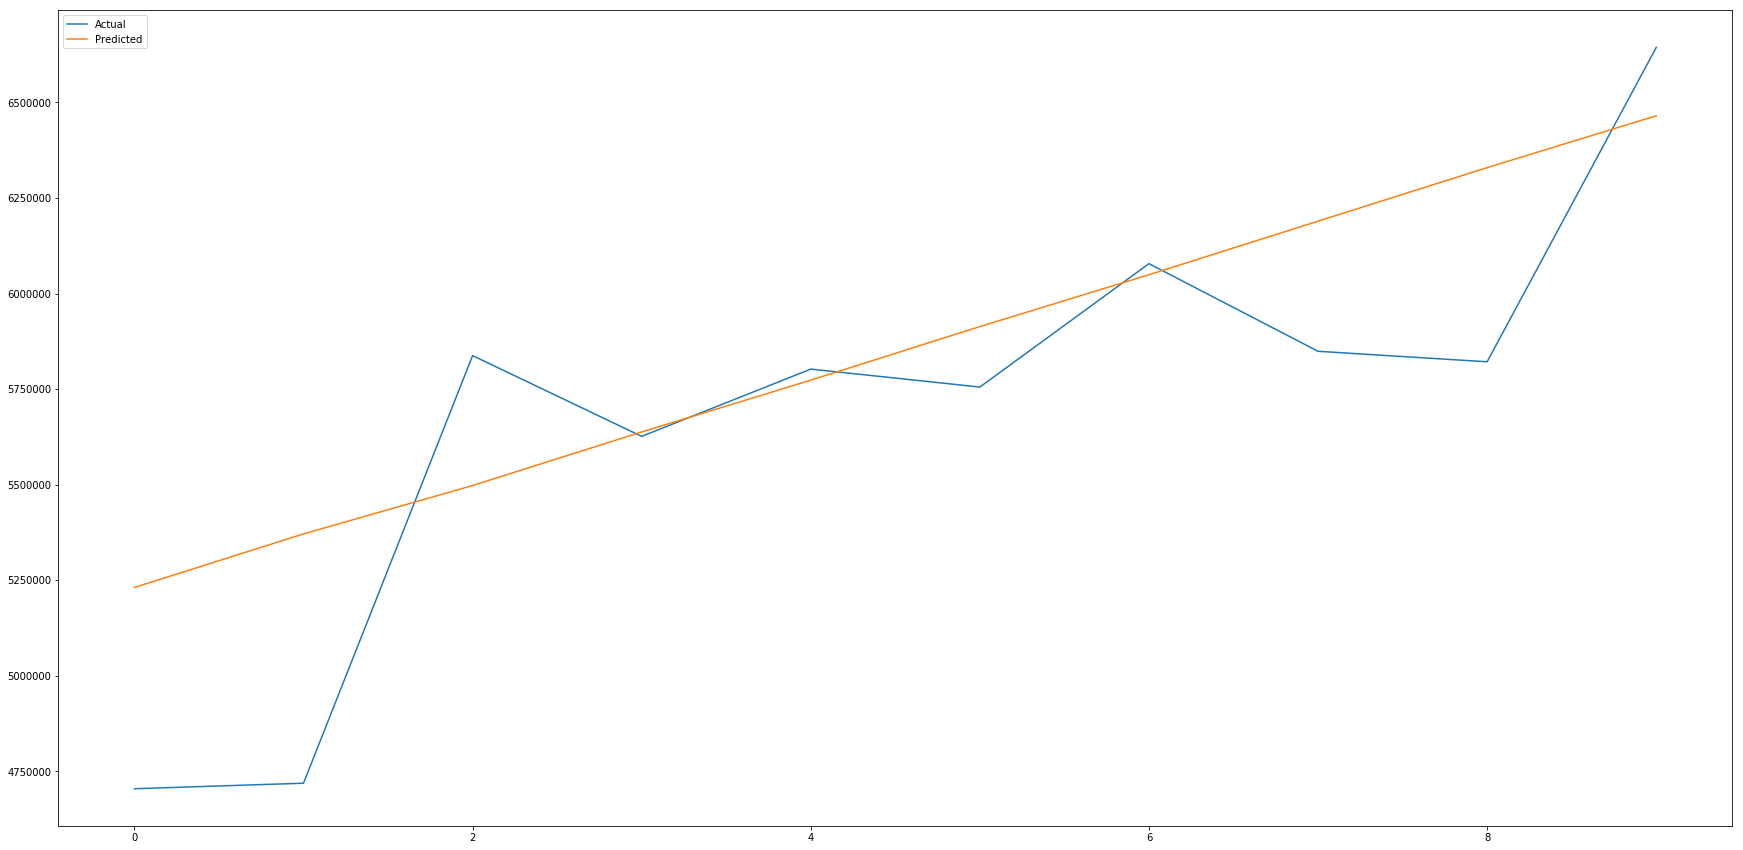

In [210]:
# calculate MAE between expected and predicted values for december
y_true = df2['y'][-10:].values
y_pred = forecast_tnc['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

          ds          yhat    yhat_lower    yhat_upper
0 2022-01-01  5.230956e+06  4.723197e+06  5.794440e+06
1 2022-02-01  5.371104e+06  4.850352e+06  5.919673e+06
2 2022-03-01  5.497690e+06  4.961510e+06  6.070986e+06
3 2022-04-01  5.637838e+06  5.088522e+06  6.200360e+06
4 2022-05-01  5.773466e+06  5.235204e+06  6.270361e+06


/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



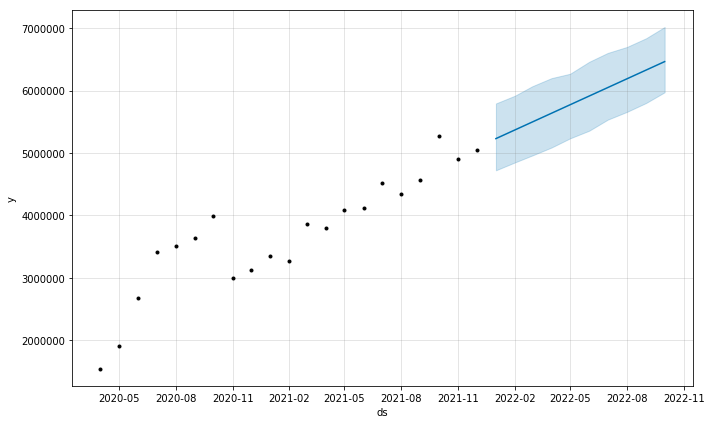

In [211]:
# summarize the forecast
print(forecast_tnc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model1.plot(forecast_tnc)
pyplot.show()

### 2. Taxi prediction model

In [277]:
# create test dataset, remove last 12 months
train_taxi = df1.drop(df1.index[-10:])
train_taxi = train_taxi.drop(train_taxi.index[:15])
print(train_taxi.head())
print(train_taxi.tail())
train_taxi.columns = ['ds', 'y']
df1.columns = ['ds', 'y']

   Trip Month Year  Trip Count
15         2020-04       55623
16         2020-05       71660
17         2020-06      102830
18         2020-07      130557
19         2020-08      142879
   Trip Month Year  Trip Count
31         2021-08      412512
32         2021-09      428595
33         2021-10      495702
34         2021-11      445351
35         2021-12      430235


In [213]:
train_taxi.shape

(21, 2)

In [214]:
# define the model
model2 = Prophet()
# fit the model
model2.fit(train_taxi)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


In [215]:
# use the model to make a forecast
forecast_taxi = model2.predict(future)

MAE: 57026.663


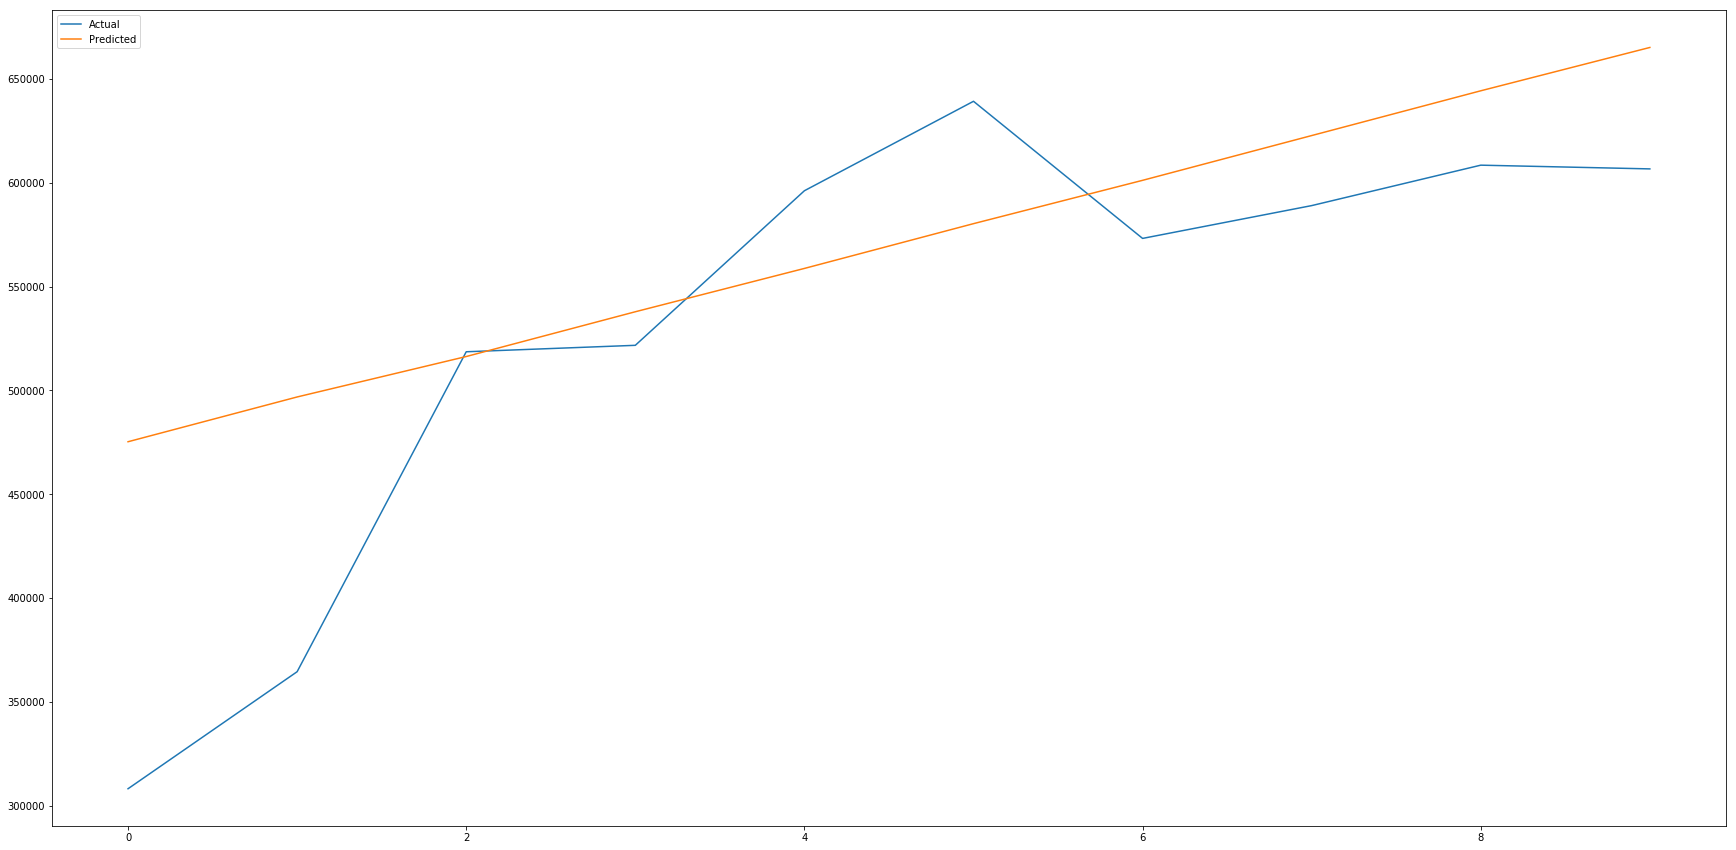

In [216]:
# calculate MAE between expected and predicted values for december
y_true = df1['y'][-10:].values
y_pred = forecast_taxi['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

          ds           yhat     yhat_lower     yhat_upper
0 2022-01-01  475304.067244  414940.778035  533679.197009
1 2022-02-01  496866.974528  442654.948686  552106.173006
2 2022-03-01  516343.148849  462136.584339  571228.029737
3 2022-04-01  537906.056133  480858.148882  592946.341759
4 2022-05-01  558773.385762  501427.432202  617632.023771


/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



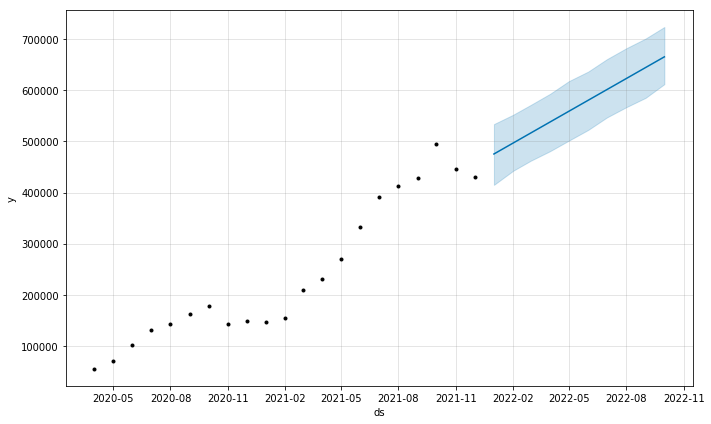

In [217]:
# summarize the forecast
print(forecast_taxi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model2.plot(forecast_taxi)
pyplot.show()

### 3. Transit prediction model

In [223]:
# create test dataset, remove last 12 months
df4 = df4.drop(['Rail','Total'],axis=1)

train_transit = df4.drop(df4.index[-10:])
train_transit = train_transit.drop(train_transit.index[:15])

train_transit.columns = ['ds', 'y']
df4.columns = ['ds', 'y']

print(train_transit.head())
print(train_transit.tail())

         ds        y
15  2020-04  5851652
16  2020-05  6822849
17  2020-06  7331691
18  2020-07  8608427
19  2020-08  8540935
         ds         y
31  2021-08  10949681
32  2021-09  12058765
33  2021-10  11905629
34  2021-11  10923926
35  2021-12  10175928


In [224]:
# define the model
model3 = Prophet()
# fit the model
model3.fit(train_transit)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


In [225]:
# use the model to make a forecast
forecast_transit = model3.predict(future)

MAE: 844227.015


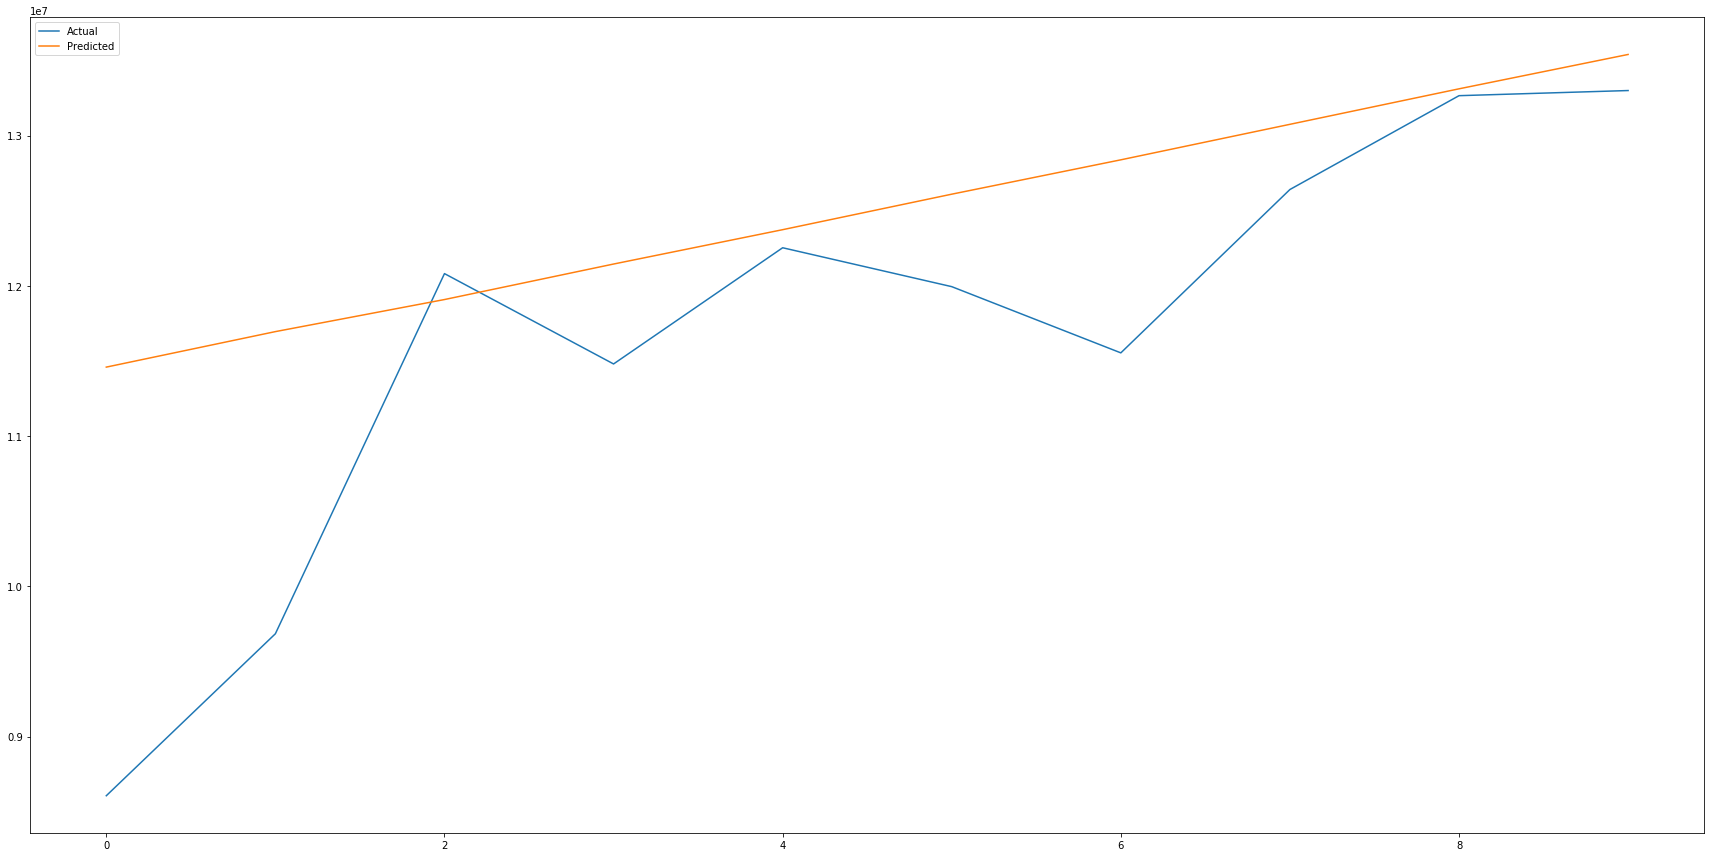

In [226]:
# calculate MAE between expected and predicted values for december
y_true = df4['y'][-10:].values
y_pred = forecast_transit['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

          ds          yhat    yhat_lower    yhat_upper
0 2022-01-01  1.145962e+07  1.019579e+07  1.271391e+07
1 2022-02-01  1.169593e+07  1.047203e+07  1.293949e+07
2 2022-03-01  1.190938e+07  1.068848e+07  1.310753e+07
3 2022-04-01  1.214569e+07  1.085610e+07  1.340283e+07
4 2022-05-01  1.237438e+07  1.104565e+07  1.358182e+07


/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



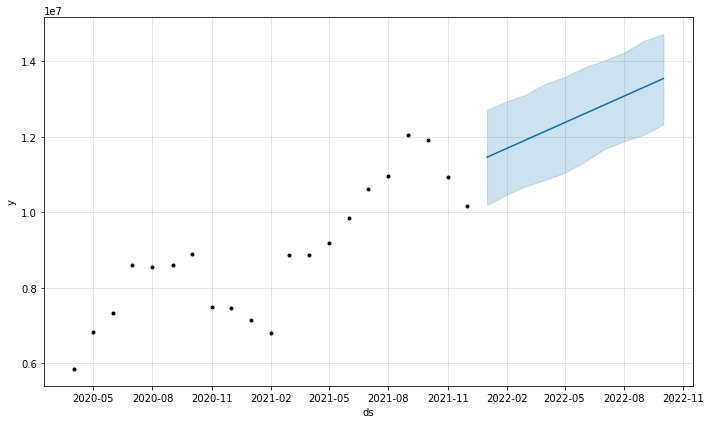

In [227]:
# summarize the forecast
print(forecast_transit[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model3.plot(forecast_transit)
pyplot.show()

### Out-sample prediction for 2023

In [228]:
future = list()
for i in range(11,13):
    future.append('2022-'+str(i))

for i in range(1,13):
    future.append('2023-'+str(i))
    
future = pd.DataFrame(future)
future.columns = ['ds']

In [229]:
future.shape

(14, 1)

In [231]:
future.head()

,ds
0,2022-11
1,2022-12
2,2023-1
3,2023-2
4,2023-3


### 1. TNC

          ds          yhat    yhat_lower    yhat_upper
0 2022-11-01  6.605315e+06  6.054827e+06  7.155088e+06
1 2022-12-01  6.740943e+06  6.219340e+06  7.280338e+06
2 2023-01-01  6.881091e+06  6.314596e+06  7.425210e+06
3 2023-02-01  7.021240e+06  6.459924e+06  7.583090e+06
4 2023-03-01  7.147825e+06  6.614422e+06  7.687140e+06


/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



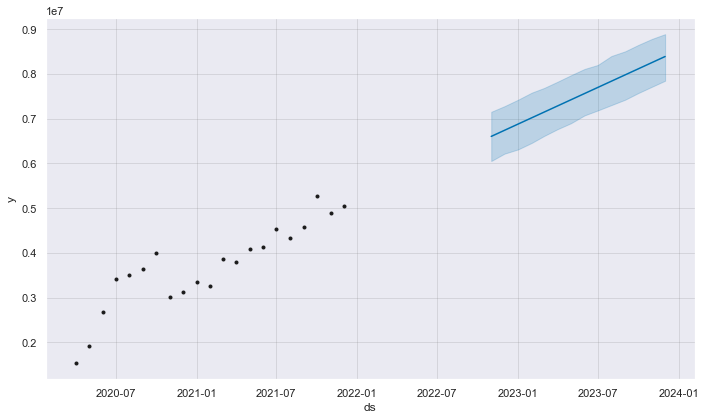

In [321]:
forecast_tnc23 = model1.predict(future)
# summarize the forecast
print(forecast_tnc23[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model1.plot(forecast_tnc23)
pyplot.show()

### 2. Taxi

          ds           yhat     yhat_lower     yhat_upper
0 2022-11-01  686759.674156  625693.107565  741968.298832
1 2022-12-01  707627.003786  649733.257948  765076.966160
2 2023-01-01  729189.911069  667939.945720  782449.194197
3 2023-02-01  750752.818353  690673.097124  812032.266012
4 2023-03-01  770228.992674  718463.690329  832057.460216


/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



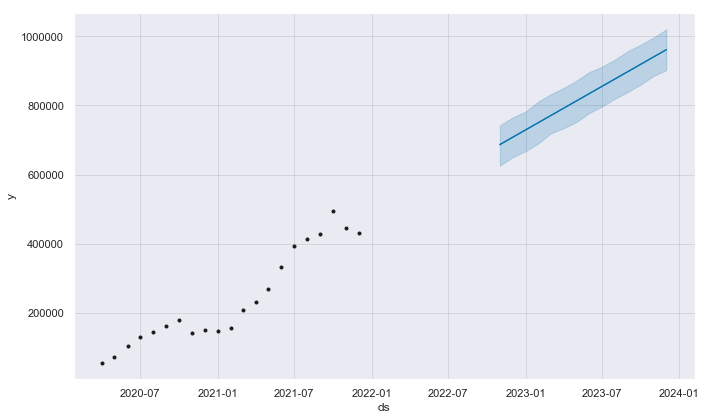

In [322]:
forecast_taxi23 = model2.predict(future)
# summarize the forecast
print(forecast_taxi23[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model2.plot(forecast_taxi23)
pyplot.show()

### 3. Transit

          ds          yhat    yhat_lower    yhat_upper
0 2022-11-01  1.377699e+07  1.255285e+07  1.493726e+07
1 2022-12-01  1.400568e+07  1.275861e+07  1.521350e+07
2 2023-01-01  1.424199e+07  1.304309e+07  1.546472e+07
3 2023-02-01  1.447830e+07  1.330263e+07  1.570322e+07
4 2023-03-01  1.469174e+07  1.341806e+07  1.589844e+07


/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/Users/xujs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:250: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



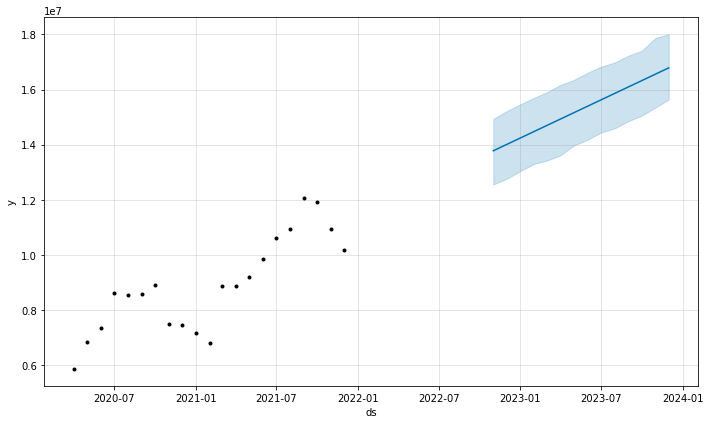

In [234]:
forecast_transit23 = model3.predict(future)
# summarize the forecast
print(forecast_transit23[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model3.plot(forecast_transit23)
pyplot.show()

### Summarizing all prediction results

In [299]:
df1.shape

(46, 2)

In [238]:
df2.shape

(46, 2)

In [240]:
df4.shape

(46, 2)

In [323]:
df1_pred = forecast_taxi23[["ds", "yhat"]]
df2_pred = forecast_tnc23[["ds", "yhat"]]
df4_pred = forecast_transit23[["ds", "yhat"]]

In [324]:
df1_pred.columns = ['ds', 'y']
df2_pred.columns = ['ds', 'y']
df4_pred.columns = ['ds', 'y']

In [332]:
df1_sum=df1.append(df1_pred)
df2_sum=df2.append(df2_pred)
df4_sum=df4.append(df4_pred)

In [333]:
df1_sum.shape

(60, 2)

In [334]:
#### row number using arange() in numpy
df1_sum['row_num'] = np.arange(len(df1_sum))
print (df1_sum)

                     ds             y  row_num
0               2019-01  1.213529e+06        0
1               2019-02  1.312782e+06        1
2               2019-03  1.515772e+06        2
3               2019-04  1.458362e+06        3
4               2019-05  1.532337e+06        4
5               2019-06  1.491272e+06        5
6               2019-07  1.319285e+06        6
7               2019-08  1.344673e+06        7
8               2019-09  1.335504e+06        8
9               2019-10  1.449433e+06        9
10              2019-11  1.247105e+06       10
11              2019-12  1.257311e+06       11
12              2020-01  1.073338e+06       12
13              2020-02  1.122124e+06       13
14              2020-03  5.575790e+05       14
15              2020-04  5.562300e+04       15
16              2020-05  7.166000e+04       16
17              2020-06  1.028300e+05       17
18              2020-07  1.305570e+05       18
19              2020-08  1.428790e+05       19
20           

In [335]:
df1_sum['ds']=df1_sum['row_num']
df1_sum.set_index('ds', inplace = True)

/Users/xujs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/xujs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



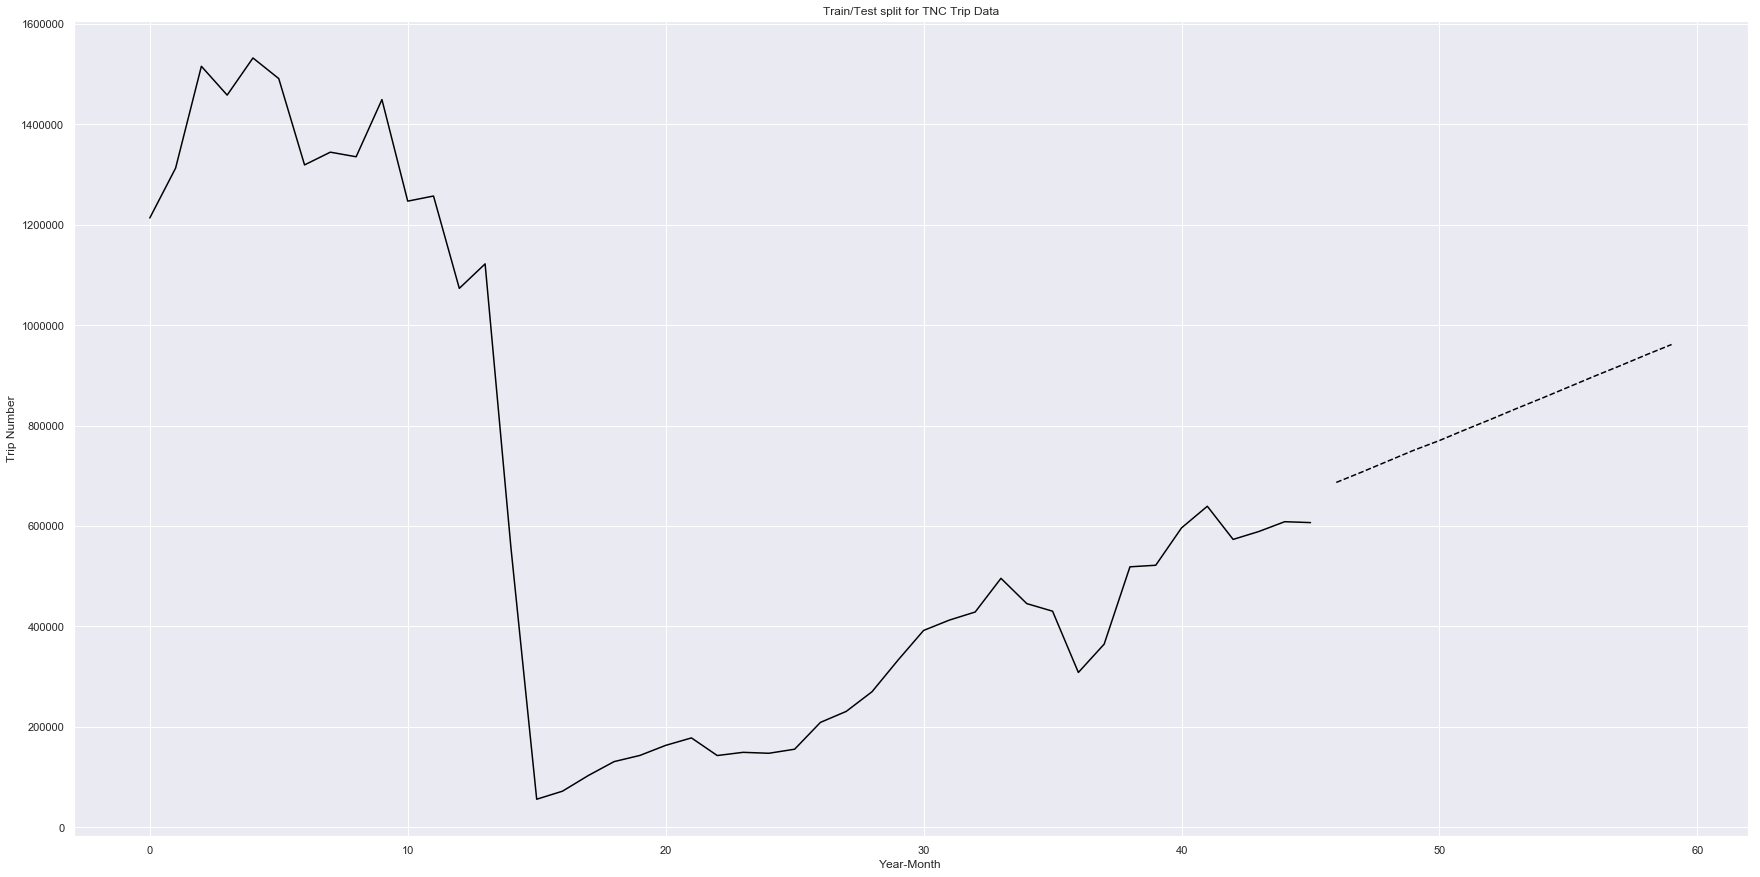

In [348]:
taxi_ori = df1_sum[df1_sum['row_num'] < 46]
taxi_ori['actural taxi trips'] = taxi_ori['y']
del taxi_ori['y']
del taxi_ori['row_num']
taxi_pre = df1_sum[df1_sum['row_num'] >= 46]
taxi_pre['predicted taxi trips'] = taxi_pre['y']
del taxi_pre['y']
del taxi_pre['row_num']
plt.plot(taxi_ori['actural taxi trips'], color = "black")
plt.plot(taxi_pre['predicted taxi trips'], color = "black", linestyle = '--')
plt.title("Train/Test split for TNC Trip Data")
plt.ylabel("Trip Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [339]:
df2_sum['row_num'] = np.arange(len(df2_sum))
df4_sum['row_num'] = np.arange(len(df4_sum))

df2_sum['ds']=df2_sum['row_num']
df2_sum.set_index('ds', inplace = True)

df4_sum['ds']=df4_sum['row_num']
df4_sum.set_index('ds', inplace = True)

In [343]:
df4_sum.tail()

,y,row_num
ds,,
55,1.585805e+07,55
56,1.609436e+07,56
57,1.632305e+07,57
58,1.655936e+07,58
59,1.678805e+07,59


In [349]:
tnc_ori = df2_sum[df2_sum['row_num'] < 46]
tnc_ori['actural tnc trips'] = tnc_ori['y']
del tnc_ori['y']
del tnc_ori['row_num']
tnc_pre = df2_sum[df2_sum['row_num'] >= 46]
tnc_pre['predicted tnc trips'] = tnc_pre['y']
del tnc_pre['y']
del tnc_pre['row_num']

transit_ori = df4_sum[df4_sum['row_num'] < 46]
transit_ori['actural transit trips'] = transit_ori['y']
del transit_ori['y']
del transit_ori['row_num']
transit_pre = df4_sum[df4_sum['row_num'] >= 46]
transit_pre['predicted transit trips'] = transit_pre['y']
del transit_pre['y']
del transit_pre['row_num']

/Users/xujs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/xujs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/xujs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

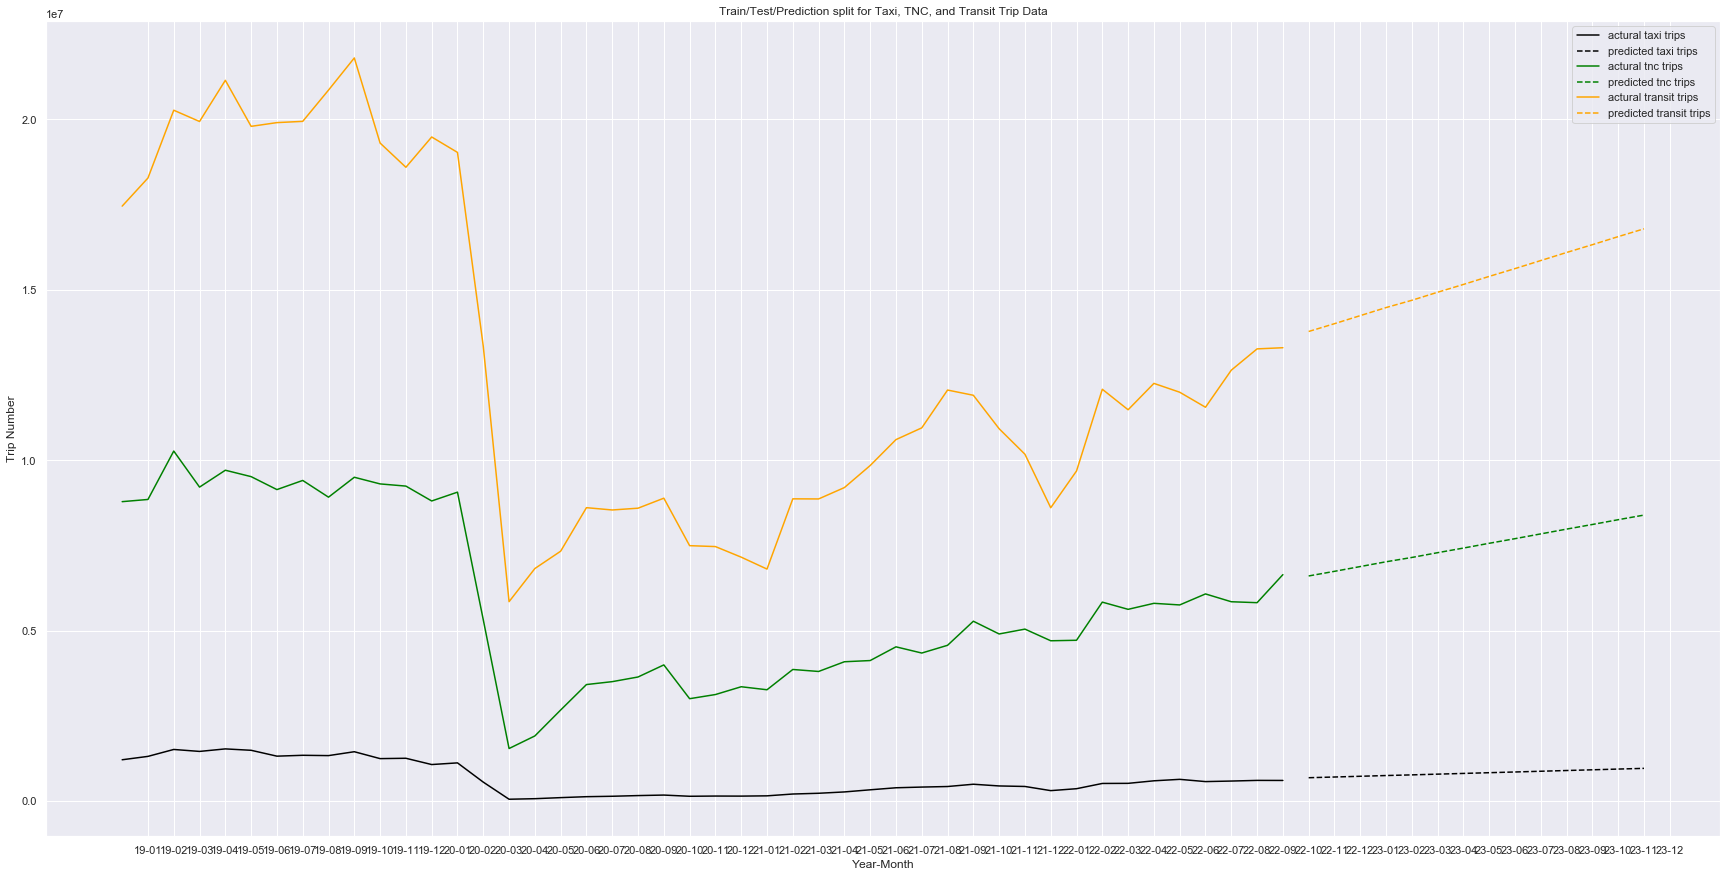

In [350]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60]
labels = ['19-01', '19-02', '19-03', '19-04', '19-05', '19-06','19-07', '19-08', '19-09', '19-10', '19-11', '19-12',
         '20-01', '20-02', '20-03', '20-04', '20-05', '20-06','20-07', '20-08', '20-09', '20-10', '20-11', '20-12',
         '21-01', '21-02', '21-03', '21-04', '21-05', '21-06','21-07', '21-08', '21-09', '21-10', '21-11', '21-12',
         '22-01', '22-02', '22-03', '22-04', '22-05', '22-06','22-07', '22-08', '22-09', '22-10','22-11', '22-12',
         '23-01', '23-02', '23-03', '23-04', '23-05', '23-06','23-07', '23-08', '23-09', '23-10','23-11', '23-12']

plt.plot(taxi_ori['actural taxi trips'], color = "black")
plt.plot(taxi_pre['predicted taxi trips'], color = "black", linestyle = '--')
plt.plot(tnc_ori['actural tnc trips'], color = "green")
plt.plot(tnc_pre['predicted tnc trips'], color = "green", linestyle = '--')
plt.plot(transit_ori['actural transit trips'], color = "orange")
plt.plot(transit_pre['predicted transit trips'], color = "orange", linestyle = '--')
plt.title("Train/Test/Prediction split for Taxi, TNC, and Transit Trip Data")
plt.ylabel("Trip Number")
plt.xlabel('Year-Month')
plt.legend()
plt.xticks(x, labels)
plt.rcParams["figure.figsize"] = (30,15)
sns.set()
plt.show()

### This exercise developes prediction models to show the projected number of trips by taxi, tnc, and transit in Chicago in 2023. Transit trips are showing the fastest rate of increase and taxi trips have the slowest increase among the three modes.